4-1. 들어가며
학습 목표
이번 시간의 목표입니다.

로이터 뉴스 데이터 이해하기
F1-score와 confusion matrix 출력해보기
여러 머신러닝 모델에 대해서 성능 비교해보기
단어 수에 따른 성능 비교해보기
준비물
터미널을 열어 실습에 필요한 디렉토리를 생성합니다.

```
$ mkdir -p ~/aiffel/reuters_classifiaction
```

머신러닝을 이용한 텍스트 분류
텍스트 분류(Text Classification)란 주어진 텍스트를 사전 정의된 클래스(Pre-defined Class)들로 분류하는 자연어 처리 태스크입니다. 이 태스크는 자연어 처리 태스크 중 가장 기본이 되면서, 비지니스 영역에서도 가장 수요가 높은 편입니다.

우리가 평소에 쉽게 접할 수 있는 텍스트 분류의 영역으로는 예를 들어 '스팸 메일 자동 분류', '사용자의 리뷰로부터 긍정, 부정을 판단하는 감성 분류', '포털 사이트가 언론사의 뉴스들을 문화, 정치 등 자동으로 분류하여 보여주는 뉴스 카테고리 분류' 등이 있습니다.

이러한 분류들을 AI 알고리즘을 통해 수행한다고 하면 일반적으로 아래와 같은 과정을 거칩니다.

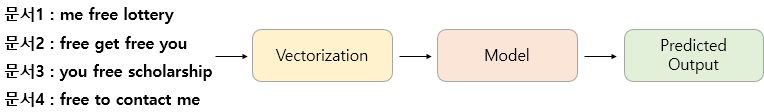

주어진 문장 또는 문서를 벡터화하고, 이를 AI 모델에 입력값으로 넣어주면 모델은 예측한 카테고리를 리턴하게 되죠. 만약, 딥러닝 모델을 사용하고 있다면 벡터화 방법으로는 워드 임베딩을 사용하고 RNN, CNN, BERT와 같은 딥러닝 모델을 사용해서 클래스를 예측할 수 있을 거예요.

하지만 AI 알고리즘에는 딥러닝이 아닌 다른 우수한 수많은 머신러닝 알고리즘들이 존재합니다. 오늘은 딥러닝이 아니라 여러 머신러닝 알고리즘을 사용해서 텍스트를 분류해 보겠습니다. 딥러닝을 사용하지 않는 상황에서 텍스트를 벡터화하여 좋은 feature를 뽑아내기 위하여, 이전 노드에서 다루었던 내용들이 어떻게 활용되는지 경험해 볼수 있을 것입니다.

텍스트 분류에도 여러 종류가 있는데 대표적으로 클래스가 2개인 경우를 이진 분류(Binary Classification)라고 하고, 클래스 3개 이상인 경우를 다중 클래스 분류(Multiclass Classification)라고 합니다. 메일이 스팸인지 아닌지를 결정하는 스팸 메일 분류기가 이진 분류의 대표적인 예일 것입니다. 오늘 우리가 하게 될 텍스트 분류는 다중 클래스 분류(Multiclass Classification)에 속하는데 구체적인 내용은 데이터를 살펴보면서 이해해 보겠습니다.

4-2. 로이터 뉴스 데이터 (1) 데이터 확인하기
우리가 사용할 데이터는 로이터 뉴스 데이터입니다. 이 데이터는 총 46개의 클래스로 구성되며, 해당 뉴스가 어느 카테고리에 속하는지를 예측하기 위한 데이터입니다. 텐서플로우 데이터셋에서 제공하고 있는 데이터로 아주 쉽게 다운로드가 가능합니다.

In [ ]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

훈련 데이터와 테스트 데이터 로드하기
텐서플로우 데이터셋으로부터 로이터 뉴스 데이터를 받아옵니다.

In [ ]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


num_words는 이 데이터에서 빈도수 기준으로 상위 몇 번째 단어까지 사용할 것인지 조절합니다. 각 단어는 고유한 번호가 정해져 있는 상태이고, 이를 통해서 사용할 단어의 수를 정하는 것이죠.

이 데이터의 단어들은 등장 빈도수가 높은 순서대로 낮은 정수가 맵핑되어져 있습니다. 예를 들어서 50번 단어보다는 10번 단어가 데이터 전체에서 빈도수가 등장 빈도 순위로 40등이 더 높은 단어입니다. 위에서 num_words=10000은 1~10,000번 단어만 사용한다는 의미입니다. 등장 빈도수가 높은 단어들만 사용하겠다는 의미지요.

그런데 주의할 점은 데이터를 받아올 때, num_words의 인자로 10,000을 기재한다고 해서 10,000보다 높은 정수가 맵핑된 단어들이 받아온 데이터에서 사라지는 게 아니라는 겁니다. num_words로 주어진 값보다 큰 번호를 가졌던 단어들은 특정 번호로 전부 맵핑이 됩니다. 이는 OOV 문제라는 자연어 처리의 대표적인 문제와 연관이 있는데요. 이에 대해서는 뒤에서 언급하겠습니다.

test_split = 0.2를 하게 되면 전체 데이터 중에서 80%를 훈련 데이터, 20%를 테스트 데이터로 사용한다는 의미입니다. x_train과 x_test가 각각 훈련용 뉴스 데이터와 테스트용 뉴스 데이터, y_train과 y_test는 각각 훈련용 뉴스 데이터의 레이블, 테스트용 뉴스 데이터의 레이블이 되는 것이지요.

이렇게 받아온 데이터가 어떤 구성을 가지고 있는지 출력해 볼까요?



In [ ]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


데이터 출력해보기
훈련용 뉴스는 8,982개. 그리고 테스트용 뉴스는 2,246개가 있네요. 8:2의 비율을 가지는데, 첫 번째 훈련용 뉴스와 첫 번째 테스트용 뉴스를 출력해 보겠습니다.

In [ ]:
print(x_train[0])
print(x_test[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]


우리는 뉴스 데이터를 다루기로 했는데, 실제 출력해보면 텍스트가 아니라 숫자 시퀀스가 출력됩니다. 사실 각 단어가 빈도수가 높은 순서대로 낮은 정수가 맵핑되어져 있다고 했었는데, 이미 뉴스 데이터를 다운받을 때는 단어가 아니라 해당 번호로 변환이 되어서 출력이 되고 있습니다.

대부분의 자연어 처리에서는 텍스트를 숫자로 수치화하는 과정이 필요한데, 텐서플로우 데이터셋에서는 이미 전처리를 한 데이터를 제공해주는 셈입니다.

이제 레이블도 출력해 볼까요? 첫 번째 훈련용 뉴스와 테스트용 뉴스의 레이블을 출력해봅시다.

In [ ]:
print(y_train[0])
print(y_test[0])

3
3


둘 다 숫자 3이 출력되네요. 각 뉴스는 정수로 된 레이블을 가지고 있군요. 이 레이블은 숫자 0부터 시작되므로, 모든 레이블 중 최댓값을 구하고 1을 더하면 현재 클래스의 개수를 볼 수 있어요.

In [ ]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


이 뉴스 데이터는 총 46개의 클래스를 가지고 있습니다. 이 정도면 적지는 않은 클래스라서 높은 정확도를 얻는 일이 쉽지는 않을 것 같은 예감이 드네요.

데이터 분포 확인해보기
자연어 처리 과정에서 문장, 문서들의 길이는 보통 다릅니다. 우리가 평소에 보는 뉴스 기사들이 길이가 항상 똑같지는 않죠. 이 데이터도 마찬가지예요. 모든 뉴스 데이터들은 길이가 다 다를 거예요. 뉴스 데이터의 길이 분포를 볼까요?

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


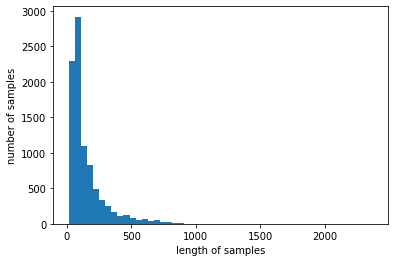

In [ ]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

길이가 가장 긴 뉴스의 길이는 2,376입니다. 평균 길이는 145구요. 아무래도 길이가 가장 긴 뉴스의 길이가 다른 뉴스에 비해 유독 긴 편인 것 같습니다. 그리고 시각화된 그래프의 분포로 봤을 때 500~1,000 사이의 길이를 가지는 뉴스도 일부 있어 보이죠?

우리가 맞춰야 하는 클래스의 분포를 확인해볼까요? 모델의 성능에 영향을 줄 수 있는 요소이기 때문에 실제로 모든 클래스가 다 존재는 하는 것인지, 또 어떤 클래스가 유독 많은지, 이런 것들을 사전에 확인해 보아야 합니다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


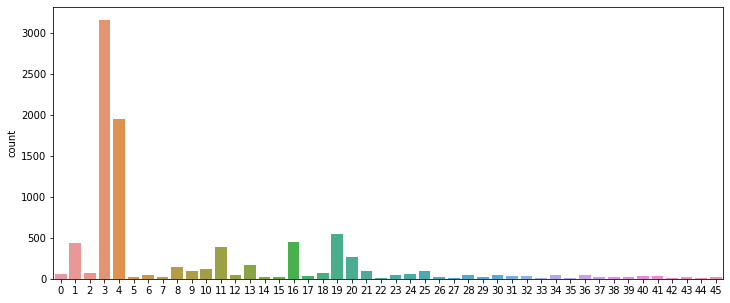

In [ ]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

이 뉴스 데이터는 3번, 4번 클래스가 대부분을 차지하고 있습니다. 그 뒤로는 19번, 16번, 1번, 11번 등이 높은 분포를 가지고 있네요. 시각화를 통해 어떤 클래스가 많고, 적은 것을 쉽게 확인할 수는 있었지만 수치적으로 정확히 몇 개인지도 출력해보겠습니다.

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


3번, 4번 클래스의 경우에는 각각 3,159개와 1,949개가 존재합니다. 그 뒤로는 549개로 19번 클래스가 세 번째로 많고, 16번 클래스가 444개로 네 번째로 많네요. 이렇게 각 클래스가 몇 개가 존재하는지도 확인해 봤어요.

4-3. 로이터 뉴스 데이터 (2) 데이터 복원하기
원본 뉴스 데이터로 복원해보기
이번에는 조금은 일반적이지 않은 전처리를 해볼 겁니다! 이 데이터는 이미 어느 정도 전처리가 되어서 각 단어가 정수 시퀀스로 변환된 채 우리에게 제공되고 있다고 언급했었어요. 하지만, 일반적인 상황이라면 텍스트를 숫자로 수치화하는 과정을 우리의 힘으로 처음부터 해야 합니다.

그래서 우리는 여기서 정수 시퀀스로 변환된 데이터를 '굳이' 다시 텍스트로 돌려보겠습니다.

아래와 같이 로이터 뉴스 데이터는 '단어'를 key값으로, 고유한 '정수'를 value로 가지는 dictionary를 제공합니다. 이를 word_index로 저장해보겠습니다.

In [ ]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

557056/550378 [==============================] - 0s 0us/step


이게 이 데이터의 단어장(Vocabulary) 입니다. 이제 word_index[] 안에 단어를 입력하면 이 단어가 어떤 정수와 맵핑이 되는지를 알 수 있습니다. 예를 들어 단어 'the'는 어떤 정수와 맵핑이 될까요?

In [ ]:
word_index['the']

1

어 'the'는 정수 1과 맵핑이 됩니다. 그렇다면, 단어 'it'은 어떤 정수와 맵핑이 될까요?

In [ ]:
word_index['it']

13

단어 'it'은 정수 13과 맵핑이 됩니다. 다른 단어들도 시도해 보세요! 그런데 지금 우리가 해야 할 일은 현재 갖고 있는 정수 시퀀스로 되어 있는 데이터를 텍스트 형태로 되돌려야 하는 일이므로 사실 word_index보다는 정수로부터 단어를 얻을 수 있는 index_word가 필요합니다.

그런데 이 데이터에는 숨겨진 비밀이 하나 있는데, 뉴스 데이터 안에서 단어 'the'는 사실 1번이 아니라 4번 단어입니다. 그리고 단어 'it'은 사실 13번 단어가 아니라 16번 단어입니다. 다른 단어들도 마찬가지로 word_index에 입력으로 했을 때, 얻는 숫자보다는 +3을 한 숫자가 원래 고유한 숫자입니다. 이건 로이터 뉴스 데이터가 정의한 일종의 약속입니다.

reuters.get_word_index에는 실제 단어에 맵핑한 정수에 -3을 한 정수를 입력해 놓았거든요. 그렇기 때문에 word_index에서 index_word를 만들 때, 각 정수에 +3을 해주어야 합니다.



In [ ]:
index_to_word = {index + 3 : word for word, index in word_index.items()}

숫자 4와 16을 넣어서 the와 it이 출력되는지 확인해볼까요?



In [ ]:
print(index_to_word[4])
print(index_to_word[16])

the
it


이 데이터를 위해 약속된 비밀은 더 있습니다. 0번, 1번, 2번은 사실 각각 
```
<pad>, <sos>, <unk>
```
라는 자연어 처리를 위한 특별한 토큰들을 위해 맵핑되어진 번호입니다. 그래서 만들어진 index_to_word에 추가적으로 이 작업을 해주어야 진짜 index_to_word가 완성됩니다.

In [ ]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

자, 이제 index_to_word를 통해서 첫 번째 훈련용 뉴스 기사를 원래 텍스트로 복원해보겠습니다!

In [ ]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [ ]:
print(x_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


첫 번째 훈련용 뉴스 기사가 정수 시퀀스에서 텍스트로 다시 원복되었습니다. 이 데이터도 어느 정도 전처리가 된 상태라서, 자연스럽게 읽히지는 않습니다. 하지만 문맥을 가진 텍스트이기 때문에, 이 데이터를 가지고 머신러닝을 시작해도 별 무리는 없어 보입니다.

원복된 첫 번째 훈련용 뉴스 기사에 특별 토큰인 \<sos>와 \<unk>가 보이는데, \<sos>는 텍스트 분류를 위한 토큰이 아니므로 크게 신경을 쓰지 않아도 됩니다. 하지만 \<unk>는 자연어 처리 전반에서 쓰이는 특별 토큰이므로 이에 대해서는 이해할 필요가 있습니다.

OOV 문제와 UNK 토큰
기계가 알고 있는 단어들의 집합을 단어장(Vocabulary)이라고 합니다. 그리고 기계가 미처 배우지 못한 모르는 단어가 등장하게 되면 이 단어를 OOV(Out-Of-Vocabulary) 또는 UNK(Unknown)이라고 표현합니다. 어떤 단어가 기계가 모르는 단어로 판단되면, 기계는 해당 단어를 전부 \<unk>라는 일관된 특별 토큰으로 변환하는 식으로 처리합니다.

앞서 우리가 가장 맨 처음 사용했던 코드를 상기해봅시다.
```
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)
```

num_words = 10000는 사실 정수 번호가 10,000이 넘는 단어들을 자동으로 \<unk> 토큰으로 처리합니다. 이 \<unk>은 로이터 뉴스 데이터에서는 정수 2번을 가지도록 약속되어져 있으므로 데이터를 로드하는 과정에서 정수 번호가 10,000이 넘는 단어들은 전부 정수 1로 변환되어서 로드가 되었던 것입니다. 아래 퀴즈에 답해보세요.


Q1. 로이터 뉴스 데이터 중 다음과 같은 정수 시퀀스가 있습니다.
```
[4, 587, 23, 133, 6, 30, 515]
```
현재 우리가 가진 index_to_word를 사용하여 이 문장을 텍스트 시퀀스로 변환해 보세요.

In [ ]:
ts = [4, 587, 23, 133, 6, 30, 515]
result=''
for w in ts:
  result += index_to_word[w]
  result += ' '

result


'the transaction is expected to be completed '

정답 문장
the transaction is expected to be completed
코드
```
print(' '.join([index_to_word[index] for index in [4, 587, 23, 133, 6, 30, 515]]))
```

Q2. 데이터를 로드하기 전 로이터 뉴스 데이터에는 다음과 같은 정수 시퀀스가 있었다고 해봅시다.

```
[4, 12000, 23, 133, 6, 30, 515]
```
그런데 만약 우리가 로이터 뉴스 데이터를 아래와 같은 코드로 데이터를 받아왔다고 해보겠습니다.

```
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)
```
실제로 로드한 데이터에서 우리가 저 문장을 출력하면 다른 정수 시퀀스가 출력되는데요. 해당 정수 시퀀스를 추측해 보세요.

예시답안
```
[4, 1, 23, 133, 6, 30, 515]
```
12,000은 10,000을 넘는 숫자로 OOV에 해당되므로 인 1로 변환되어 데이터가 로드됩니다.

이제 전체 훈련용 뉴스 데이터와 전체 테스트용 뉴스 데이터를 텍스트 데이터로 변환해 보겠습니다.

In [ ]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

In [ ]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

각각 5개씩 출력해보고, 제대로 변환이 되었는지 확인해 보겠습니다.



In [ ]:
x_train[:5]

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3',
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for o

In [ ]:
x_test[:5]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> yulo said yulo told reuters a survey during the curren

4-4. 벡터화 하기
원활한 실습을 위해 아래의 도구들을 먼저 임포트하겠습니다.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

앞서 본 텍스트 분류의 과정을 표현한 그림을 다시 보겠습니다.

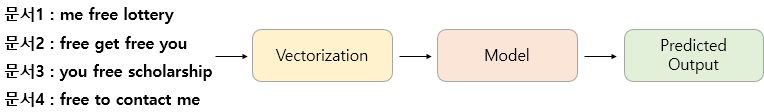

텍스트 데이터가 있을 때, 모델의 입력으로 넣기 위해서는 우선 각 문서를 벡터화할 필요가 있습니다. 항상 그런 것은 아니지만, 일반적으로 텍스트 분류를 할 모델로 인공 신경망을 사용하는 경우, 벡터화 방법 또한 인공 신경망을 사용하는 것이 보편적입니다. Word Embedding, Document Embedding, Contextual Embedding 등 다양한 벡터화 방법이 존재하는데요.

이번 실습에서는 딥러닝이 아닌 머신러닝 방법을 사용하여 텍스트 분류를 진행할 예정이니만큼, 벡터화 방법도 인공 신경망이 아닌 방법을 사용하겠습니다. 저희가 사용할 벡터화 방법은 Bag of Words 가설을 기반으로 하는 DTM, TF-IDF 행렬입니다.

Bag of Words 가설과 이를 통해 만드는 DTM에 대한 정의는 아래의 링크를 통해 알아보겠습니다.

[위키독스: 문서 단어 행렬(DTM)](https://wikidocs.net/24559)


Q3. (O/X 퀴즈) 총 3개의 문서가 있습니다. 단어 단위로 토크나이징을 하였을 때, 첫 번째 문서의 길이가 3, 두 번째 문서의 길이가 2, 세 번째 문서의 길이가 4로 나왔습니다. 이 세 개의 문서로부터 만든 DTM의 열의 개수는 9입니다. (O/X)

예시답안
X
DTM의 열의 개수는 중복을 제거한 단어들의 집합인 단어장(Vocabulary)의 크기를 가지므로 반드시 9라고 할 수는 없습니다. 문서 내 단어가 중복되어 있다면 9보다 작을 수 있습니다.

Q4. DTM을 기반으로 문서를 군집하거나, 분류를 한다면 같은 단어가 많이 등장한 문서들일수록 그 유사도가 높다고 판단할 수 있을 것입니다. 군집이나 분류 시에 이러한 가정을 사용할 때 성능을 저하시킬 수 있는 요소가 있다면 무엇이 있을까요?

예시답안
불용어는 모든 문서에 자주 등장하지만 실제로 중요한 의미를 가지지는 않으므로 이러한 가정에서는 성능 저하의 원인이 될 수 있습니다.


Document Term Matrix, DTM은 사이킷런의 CountVectorizer()를 통해서 생성할 수 있습니다.

DTM을 생성하고, DTM의 크기를 확인해보겠습니다.

In [ ]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 9670)


훈련용 뉴스의 수가 총 8,982개였기 때문에 DTM의 행의 개수는 8,982개가 됩니다. 그런데 이상한 점은 앞에서 데이터를 로드할 때, num_words=10,000이라는 값을 사용했음에도 DTM 열의 개수는 이보다 현저하게 적은 9,670개밖에 되지 않습니다.이는 DTM이 자체적인 규칙에 따라서 불필요하다고 판단하는 토큰들을 제거하기 때문입니다.

DTM 행렬을 이어서 TF-IDF 행렬을 만들어보겠습니다. TF-IDF 행렬은 퀴즈 4에서 알아본 DTM의 단점을 보정해주는 효과를 가지고 있습니다. TF-IDF 행렬에 대한 설명은 아래의 글을 참고하겠습니다.

[위키독스: TF-IDF](https://wikidocs.net/31698)

Q5. (O/X 퀴즈) TF-IDF 행렬은 모든 문서에 걸쳐서 중요하다고 판단되는 단어에 가중치를 주는 효과를 가지고 있습니다. 만약, 모든 문서에 걸쳐서 자주 등장하는 단어라면 TF-IDF는 다른 단어들보다 상대적으로 높은 가중치를 주게 됩니다.

예시답안
X
모든 문서에 걸쳐서 자주 등장한다면 다른 단어들보다 중요도가 낮은 단어로 판단합니다.


In [ ]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 9670)


#4-5. 나이브 베이즈 분류기


In [ ]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

먼저 아래 영상을 통해서 나이브 베이즈 분류기에 대해 간단히 알아보겠습니다.

https://youtu.be/3JWLIV3NaoQ


Q6. 모든 메일에는 같은 단어가 중복으로 등장하지 않는다고 가정하였을 때, 베이즈 정리만을 이용하여 coupon이라는 단어가 들어갔을 때 해당 메일이 스팸 메일일 확률을 구해보세요. 가정은 아래와 같습니다!


```
총 8개의 메일 중에 4개의 메일이 스팸 메일입니다.

전체 메일 중에서 coupon이라는 단어가 들어간 메일은 3개입니다.

모든 스팸 메일 중에서 단어 coupon이 들어간 메일은 2개입니다.

예시답안

총 8개의 메일 중 4개의 메일이 스팸 메일이므로 P(spam) = 4/8 = 1/2

총 8개의 메일 중 3개의 메일이 coupon이라는 단어를 포함하므로 P(coupon) = 3/8

총 4개의 스팸 메일 중 2개의 메일이 coupon이라는 단어를 포함하므로 P(coupon | spam) = 2/4 = 1/2


P(coupon | spam)과 P(spam)를 곱한 후에 P(coupon)로 나눠줍니다.
정답은 2/3 즉, 66.7%입니다.
```

나이브 베이즈 분류기는 사이킷런의 MultinomialNB()를 통해 사용할 수 있습니다.

사이킷런이 제공하는 머신러닝 모델들은 공통적으로 fit()이라는 함수를 제공하고 있는데요.

훈련 데이터와 해당 훈련 데이터에 대한 레이블을 인자로 사용하면 모델이 이를 학습합니다.


In [ ]:
mod = MultinomialNB()
mod.fit(tfidfv, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

테스트 데이터에 대한 정확도를 측정하기 위해서는 훈련 데이터와 동일한 전처리를 거쳐야 합니다. 다시 말해 테스트 데이터도 TF-IDF 행렬로 변환해 주어야 합니다. 그리고 해당 행렬과 predict() 함수를 통해 예측값을 얻어 정확도를 측정합니다.

In [ ]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6567230632235085


65%의 정확도를 얻습니다. 사실 그렇게 좋은 성능은 아닙니다. 뒤에서 다른 모델들을 통해서 더 좋은 성능을 얻기 위해서 노력해 봅시다.

나이브 베이즈 분류기가 임의의 샘플에 대해서 클래스를 정확히 예측하는지 테스트를 해보겠습니다. 네 번째 샘플(인덱스 상으로는 3)의 원문을 출력하면 다음과 같습니다.

In [ ]:
x_test[3]

'<sos> <unk> <unk> oil and gas partnership said it completed the sale of interests in two major oil and gas fields to lt energy assets international corp for 21 mln dlrs the company said it sold about one half of its 50 pct interest in the oak hill and north <unk> fields its two largest producing properties it said it used about 20 mln dlrs of the proceeds to <unk> principal on its senior secured notes semi annual principal payments on the remaining 40 mln dlrs of notes have been satisfied until december 1988 as a result it said the company said the note agreements were amended to reflect an easing of some financial covenants and an increase of interest to 13 5 pct from 13 0 pct until december 1990 it said the <unk> exercise price for 1 125 000 warrants was also reduced to 50 cts from 1 50 dlrs the company said energy assets agreed to share the costs of increasing production at the oak hill field reuter 3'

이 샘플의 레이블은 몇이었을까요?

In [ ]:
y_test[3]

4

이 샘플의 레이블은 4네요. 과연 모델은 제대로 예측하고 있는지 그리고 어느 정도의 확신을 가지고 판단하는지 모델이 결정한 확률을 그래프로 시각화해봅시다.

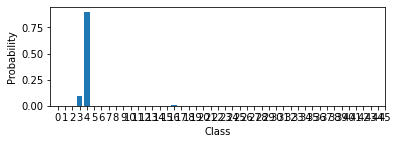

In [ ]:
plt.subplot(211)
plt.rcParams["figure.figsize"] = (10,10)
plt.bar(mod.classes_, mod.predict_proba(tfidfv_test[3])[0])
plt.xlim(-1, 21)
plt.xticks(mod.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [ ]:
mod.predict(tfidfv_test[3])

array([4])

모델은 4번 클래스를 약 90%의 확률로 확신하는데, 10%의 확률로 3번 클래스라고 판단합니다. 90%의 확률로 확신하므로 모델이 예측한 레이블은 4번입니다. 해당 샘플은 정확하게 예측했네요.


# 4-6. F1-Score, Confusion Matrix

오늘의 실습에서는 성능 비교를 위한 척도로 정확도(Accuracy)를 사용합니다. 하지만 Accuracy 외에 또 다른 방법인 F1-score도 존재하는데요.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Precision, Recall & F1 Score
아래의 글을 통해서 Precision과 Recall 그리고 F1 score에 대한 설명을 읽어봅시다.

분류성능평가지표 - Precision(정밀도), Recall(재현율) and Accuracy(정확도)
Q7. Accuracy는 가장 직관적으로 모델의 성능을 나타낼 수 있는 평가 지표입니다. 하지만, [   ]인 경우를 제대로 고려하지 못하기 때문에 [   ]인 경우에는 이를 고려한 f1-score를 사용하기도 합니다. [   ]에 들어갈 설명은 무엇일까요?

label 불균형

사이킷런의 metrics 패키지에서는 정밀도, 재현율, F1점수를 구하는 classification_report() 함수를 제공합니다. 이 함수는 각각의 클래스를 양성(positive) 클래스로 보았을 때의 정밀도, 재현율, F1점수를 각각 구하고 그 평균값으로 전체 모델의 성능을 평가합니다.



In [ ]:
print(classification_report(y_test, mod.predict(tfidfv_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.69      0.65       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.63      0.64        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.69      0.56      0.61        99
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


최종 결과에서 각각이 의미하는 바는 다음과 같습니다.

macro: 단순평균
weighted: 각 클래스에 속하는 표본의 개수로 가중평균
accuracy: 정확도. 전체 학습 데이터의 개수에서 클래스를 정확하게 맞춘 개수의 비율.
Confusion Matrix
Confusion Matrix는 사실 생소한 개념이라기보다는 앞서 f1-score를 이해하기 위해 읽었던 위의 글의 가장 처음에 있던 행렬입니다. Confusion matrix를 아래의 동영상을 통해 이해해 봅시다.

https://youtu.be/M0GBAzFV9_A


지금까지 배운 내용들을 아래의 링크를 통해 간단히 정리해 보겠습니다!

[Confusion Matrix 혼동 행렬](https://mjdeeplearning.tistory.com/31)
Q8. TP와 FN에 대해서 각각 설명해보세요.
예시답안
TP는 True로 예측하고 실제 값도 True, FN은 False로 예측하고 실제는 True

아래의 함수를 통해서 혼동 행렬(confusion matrix)을 시각화할 수 있습니다.




In [ ]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(15,15))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

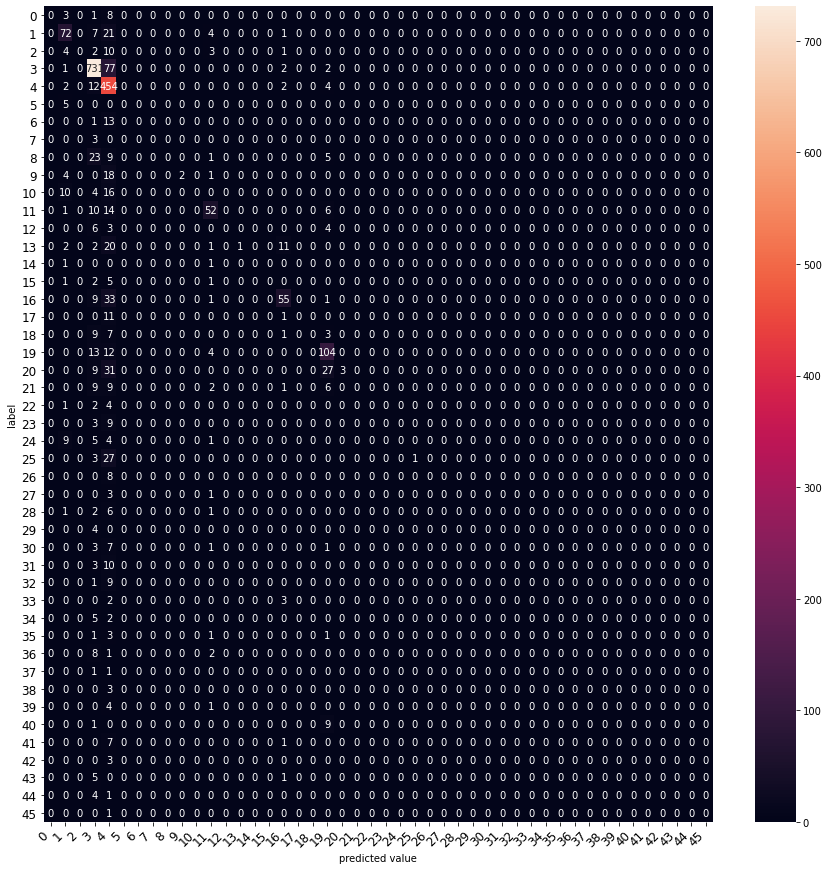

In [ ]:
graph_confusion_matrix(mod, tfidfv_test, y_test)

# 4-7. 다양한 머신러닝 모델 사용해보기 (1)
앞서 사용한 나이브 베이즈 분류기(MultinomialNB)로는 65%의 정확도밖에 얻지 못했습니다. 사실 클래스의 개수가 46개인 것을 감안해도 그리 좋은 성능은 아닙니다. 좀 더 좋은 성능을 얻기 위해서 여러 다른 모델들을 시도해 봅시다.

Complement Naive Bayes Classifier(CNB)
나이브 베이지안 분류기는 조건부로 독립적이라는 가정을 하기 때문에, 문서가 특정 분류에 속할 실제 확률로 사용할 때 문제가 발생할 수 있습니다. 바로 많은 샘플(sample)이 특정 클래스에 치우쳐져 있을 경우, 결정 경계의 가중치가 한쪽으로 치우쳐져 모델이 특정 클래스를 선호할 수 있다는 점인데요. 앞서 우리는 로이터 뉴스 데이터에서 3번, 4번 클래스가 다른 클래스에 비해 상대적으로 많은 클래스를 갖고 있음을 확인했었죠.

이렇게 데이터가 불균형할 경우를 대비해서 나이브 베이즈 분류기를 보완한 것이 컴플리먼트 나이브 베이즈 분류기입니다. 컴플리먼트 나이브 베이즈 분류기는 데이터의 불균형을 고려하여 가중치를 부여하는 특징을 가지고 있습니다. 컴플리먼트 나이브 베이즈 분류기는 앞서 사용한 나이브 베이즈 분류기 즉, MultinomialNB보다 성능이 일반적으로 더 좋다고 할 수 있습니다.

In [ ]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [ ]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7707034728406055


로지스틱 회귀(Logistic Regression)
다음으로는 가장 널리 알려진 두 개의 선형 분류 알고리즘인 로지스틱 회귀와 서포트 벡터 머신을 통해서 로이터 뉴스를 분류해 봅시다.

로지스틱 회귀는 소프트맥스(softmax) 함수를 사용한 다중 클래스 분류 알고리즘을 지원합니다. 다중 클래스 분류를 위한 로지스틱 회귀를 소프트맥스 회귀(Softmax Regression)라고도 합니다. 주의할 점은 이름은 회귀지만, 실제로는 분류를 수행한다는 점입니다.

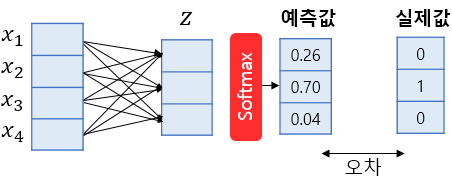


소프트맥스 함수는 클래스가 N개일 때, N차원의 벡터가 각 클래스가 정답일 확률을 표현하도록 정규화를 해주는 함수입니다. 예를 들어 위의 그림은 4차원의 벡터를 입력으로 받으면서 3개의 클래스를 가지는 경우의 소프트맥스 회귀의 동작 과정을 보여주고 있습니다. 3개의 클래스 중 1개의 클래스를 예측해야 하므로 소프트맥스 회귀의 출력은 3차원의 벡터고, 각 벡터의 차원은 특정 클래스일 확률입니다. 그리고 오차와 실제값의 차이를 줄이는 과정에서 가중치와 편향이 학습됩니다.

사이킷런에서 소프트맥스 회귀는 LogisticRegression()을 통해서 구현할 수 있습니다.



In [ ]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8076580587711487


80%의 정확도를 얻었습니다. 지금까지의 모델 중 가장 높은 정확도를 얻었습니다.

선형 서포트 벡터 머신
서포트 벡터 머신은 대표적인 선형 분류 알고리즘입니다.

아래의 영상을 통해 서포트 벡터 머신에 대해서 이해해보겠습니다.

https://youtu.be/y4CYcpRiNsw

Q9. 서포트 벡터 머신에서 서포트 벡터란 어떤 벡터를 의미하는지 설명해보세요.

많은 선형 분류 모델은 태생적으로는 이진 분류만을 지원하는 이진 분류 모델입니다. (위에서 설명한 로지스틱 회귀는 예외입니다.) 서포트 벡터 머신의 구현체인 사이킷런의 LinearSVC 또한 태생적으로는 이진 분류를 위한 모델입니다. 그런데 이진 분류 알고리즘을 다중 클래스 분류 알고리즘으로 사용하는 방법이 있습니다. 바로 일대다(one-vs.-rest 또는 one-vs.-all) 방법입니다. 일대다 방식은 각 클래스를 다른 모든 클래스와 구분하도록 이진 분류 모델을 학습시킵니다.

결국 클래스의 수만큼 이진 분류 모델이 만들어집니다. 예측할 때는 만들어진 모든 이진 분류기가 작동하여 가장 높은 점수를 내는 분류기의 클래스를 예측값으로 선택합니다. 서포트 벡터 머신을 사용하여 로이터 뉴스를 분류해봅시다.

In [ ]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=500,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7711487088156723


# 4-8. 다양한 머신러닝 모델 사용해보기 (2)
결정 트리(Decision Tree)
결정 트리는 분류와 회귀 문제에 널리 사용하는 모델입니다. 기본적으로 결정 트리는 결정에 다다르기 위해 예/아니오 질문을 이어 나가면서 학습합니다. 이 질문은 스무고개 놀이의 질문과 비슷합니다. 아래의 영상을 통해서 결정 트리에 대해서 이해해봅시다.

https://youtu.be/n0p0120Gxqk

사이킷런에서는 DecisionTreeClassifier()를 사용해서 결정 트리를 구현할 수 있습니다. 결정 트리의 깊이는 max_depth라는 인자를 통해서 정해줄 수 있습니다.

In [ ]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6202137132680321


지금까지의 모델 중 가장 낮은 정확도인 62%를 얻습니다. 사실 트리 계열의 모델들은 고차원이고 희소한 데이터에 대해서는 성능이 나오지 않는다는 특징이 있습니다. DTM이나 TF-IDF 행렬의 경우 고차원이면서 대부분의 값이 0인 희소한 데이터이므로 트리 계열의 모델보다는 선형 분류 모델을 통해 접근하는 것이 더 나은 접근일 수 있습니다.

## 랜덤 포레스트(Random Forest)

앙상블(Ensemble)이란 여러 머신러닝 모델을 연결하여 더 강력한 모델을 만드는 기법입니다. 뒤에서 보팅(Voting)이라는 앙상블 기법을 알아볼 텐데, 모델 자체가 앙상블을 사용하는 앙상블 모델들도 존재합니다. 랜덤 포레스트와 그래디언트 부스팅 트리는 결정 트리를 사용하는 앙상블 모델입니다.

랜덤 포레스트에 대해서 아래의 영상을 통해서 이해해보겠습니다.

https://youtu.be/nZB37IBCiSA

Q10. 위 영상에서 언급된 결정 트리의 단점을 랜덤 포레스트는 해결할 수 있다고 합니다. 영상에서 언급된 단점이 무엇이었는지 언급해보고 랜덤 포레스트가 어떻게 그 문제를 해결할 수 있는지 토의해봅시다.

예시답안
결정 트리는 훈련 데이터에 과적합(Overfitting) 되는 경향이 있습니다. 랜덤 포레스트는 이 문제를 앙상블로 해결합니다. 가령, 서로 다른 방향으로 과적합 된 트리들을 조합하면 오히려 모델 전체에서는 과적합을 피할 수 있다는 것이죠.

랜덤 포레스트로 모델을 훈련시키고, 테스트 데이터에 대해서 정확도를 평가해 봅시다.

In [ ]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.674087266251113


그래디언트 부스팅 트리(GradientBoostingClassifier)
그래디언트 부스팅 트리는 여러 개의 결정 트리를 묶어 만드는 앙상블 모델입니다. 그레디언트 부스팅은 랜덤 포레스트와 다르게 이전 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만듭니다.

그래디언트 부스팅 트리는 일부 특성을 무시한다는 특징을 가지고 있습니다. 그래서 보통 랜덤 포레스트를 먼저 사용해보고, 성능이나 예측 시간 면에서 만족스럽지 않은 경우에 그래디언트 부스팅 트리를 시도해보는 것이 좋습니다.

일반적으로 1 ~ 5 정도의 깊지 않은 트리를 사용하므로 메모리도 적게 사용하고 예측도 빠릅니다.

정확도도 준수하고, 특히 예측 속도가 빠르다는 점에서 데이터 경진 대회에서 많은 우승을 했던 모델입니다. 다만, 훈련 시간의 속도가 좀 오래 걸린다는 단점이 있으며 트리 기반 모델의 특성으로 인해서 희소한 고차원 데이터에 대해서는 잘 동작하지 않는다는 단점이 있습니다.

현재 우리가 사용하는 TF-IDF 행렬은 희소하고 고차원 데이터지만, 결정 트리나 랜덤 포레스트보다 더 높은 성능을 얻을 수 있을지 한번 테스트해 볼까요?

저는 아래 코드 실행에 약 12분 정도 소요되었습니다. verbose=3을 GradientBoostingClassifier안에 인자로 넣어 진행 상황을 확인할 수 있으니 참고해 주세요!



In [ ]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7680320569902048


76%의 정확도로 결정 트리와 랜덤 포레스트와 비교하여 좋은 성능을 얻었습니다.


## 보팅(Voting)
데이터 경진 대회 캐글(Kaggle)에서 상위권을 차지한 나오는 많은 솔루션들이 앙상블(Ansemble learning)이라는 방법을 사용합니다. 그중에서 오늘은 투표를 통해 결과를 도출하는 보팅(Voting)이라는 방법에 대해서 이해해 봅시다.

https://youtu.be/y4Wh0E1d4oE

Q11. 보팅은 하드 보팅과 소프트 보팅 두 가지로 나누어집니다. 하드 보팅은 결과물에 대한 최종값을 투표해서 결정합니다. 그렇다면, 소프트 보팅의 결정 방식에 대해 설명해보세요.

예시답안
소프트 보팅은 최종 결과물이 나올 확률값을 다 더해서 최종 결과물에 대한 각각의 확률을 구한 뒤 최종값을 도출해 냅니다.

이전에 사용했던 모델인 로지스틱 회귀, CNB, 그래디언트 부스팅 트리 세 가지를 사용하여 소프트 보팅을 하였을 때의 성능을 비교해봅시다.

In [ ]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10000, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('cb',
                              ComplementNB(alpha=1.0, class_prior=None,
                                           fit_prior=True, norm=False)),
                             ('...
                                                         max_leaf_nodes=

In [ ]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8130008904719501


오늘의 실습 중 가장 높은 정확도를 보였던 소프트맥스 회귀보다 좀 더 높은 정확도를 얻었습니다.

4-9. 프로젝트: Vocabulary Size를 변경해서 시도해보기
지금까지는 모델을 변경하고, 모델을 조합해서 성능을 올리는 일에 힘썼습니다. 그런데 어쩌면 성능을 높이는 방법은 단순히 모델을 조정하는 일이 한정되지 않을 수 있습니다. 데이터의 전처리는 모델의 성능에 영향을 직접적으로 줍니다. 특히나 Bag of Words를 기반으로 하는 DTM이나 TF-IDF의 경우, 사용하는 단어의 수를 어떻게 결정하느냐에 따라서 성능에 영향을 줄 수 있겠죠.

중요도가 낮은 단어들까지 포함해서 너무 많은 단어를 사용하는 경우에도 성능이 저하될 수 있고, 반대로 너무 적은 단어들을 사용해도 성능이 저하될 수 있습니다. 그리고 이렇게 변화된 단어의 수는 또 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있습니다.

단어의 수에 따라서 모델의 성능이 어떻게 변하는지 테스트해 봅시다.
```
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)
```

앞서 num_words로 사용할 단어의 수를 조정할 수 있다는 것을 배웠습니다. 빈도수가 많은 순서대로 나열했을 때, num_words의 인자로 준 정숫값만큼의 단어를 사용하고 나머지 단어는 전부 \<unk>로 처리하는 원리였었죠.

아래의 두 가지 경우에 대해서 지금까지 사용했던 모델들의 정확도를 직접 확인해 보세요.

1. 모든 단어 사용
```
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
```
2. 빈도수 상위 5,000개의 단어만 사용
```
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)
```

3. 직접 단어 갯수를 설정해서 사용
위 단계에서 5000으로 제시된 num_words를 다양하게 바꾸어 가며 성능을 확인해보세요. 변화된 단어 수에 따른 모델의 성능을 연구해 보세요. 최소 3가지 경우 이상을 실험해 보기를 권합니다.

사용할 모델

나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤 포레스트, 그래디언트 부스팅 트리, 보팅

4. 딥러닝 모델과 비교해 보기
위 과정을 통해 나온 최적의 모델과 단어 수 조건에서, 본인이 선택한 다른 모델을 적용한 결과와 비교해 봅시다. 감정분석 등에 사용했던 RNN이나 1-D CNN 등의 딥러닝 모델 중 하나를 선택해서 오늘 사용했던 데이터셋을 학습해 보고 나오는 결과를 비교해 봅시다. 단, 공정한 비교를 위해 이때 Word2Vec 등의 pretrained model은 사용하지 않도록 합니다.